# Covid-19 Effect on Air Pollution

* The main purpose of this study is correctly predicting the countries/cities air pollution change with the machine learning algorithms such as XGBoost, Random Forest, K-Nearest Neighbor.

In [1]:
# General Libraries for Data Analysis and Visualization
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Statistics
import statsmodels.stats.api as sms

# Classification
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Standardization
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics 
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, plot_roc_curve
# Validation
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Load data set
data = pd.read_csv("covid_data.csv")
data.head()

,Country,City,Country_Population,Total_Day_Lockdown,Avg_Pollution_2020,Avg_Pollution_2019,Development,Total_Case,Total_Death,Latitude,Longitude,Change
0,United Arab Emirates,Dubai,9890400,23,86.0,95,1,22627,214,23.424076,53.847818,1
1,Argentina,Buenos Aires,45195777,60,35.9,35,0,7792,363,-38.416097,-63.616672,0
2,Austria,Vienna,9006400,29,44.0,50,1,16140,628,47.516231,14.550072,1
3,Australia,Melbourne,25499881,56,31.0,28,1,7036,98,-25.274398,133.775136,0
4,Bangladesh,Dhaka,25499881,31,175.0,210,0,7036,98,23.684994,90.356331,1


* **Country:** name of the countries
* **City:** name of the city
* **Total_Day_Lockdown:** how many day lockdown applied to the country
* **Avg_Pollution_2020:** average air pollution level for the specific time periods in 2020
* **Avg_Pollution_2019:** average air pollution level for the specific time periods in 2019
* **Development:** if the country developed according to the World Bank GDP per capita (if it is above the 12000$ threshold level), 1. Otherwise 0.
* **Total_Case:** total number of Covid-19 cases until May 17, 2020
* **Total_Death:** total number of death because of Covid-19 until May 17,2020
* **Latitude:** latitiude of the country
* **Longitude:** longitude of the country
* **Change:** if there is a decrease in the air pollution level in 2020 compared to 2019, 1. Otherwise, 0. 

## Descriptive Statistics

In [3]:
data.shape

(47, 12)

* There are 47 observation and 12 attributes in the dataset.

In [4]:
data.isnull().values.any()

False

* There is no mising value in the dataset.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             47 non-null     object 
 1   City                47 non-null     object 
 2   Country_Population  47 non-null     int64  
 3   Total_Day_Lockdown  47 non-null     int64  
 4   Avg_Pollution_2020  47 non-null     float64
 5   Avg_Pollution_2019  47 non-null     int64  
 6   Development         47 non-null     int64  
 7   Total_Case          47 non-null     int64  
 8   Total_Death         47 non-null     int64  
 9   Latitude            47 non-null     float64
 10  Longitude           47 non-null     float64
 11  Change              47 non-null     int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 4.5+ KB


- There are two categorical variables in the dataset.

- There are 10 numerical attributes.  

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Country_Population,47.00,101724795.60,286095427.06,2722291.00,6369824.50,19116209.00,55672356.00,1439323774.00
Total_Day_Lockdown,47.00,41.28,16.55,7.00,29.50,43.00,55.50,77.00
Avg_Pollution_2020,47.00,61.04,37.24,2.00,38.00,44.00,82.50,175.00
Avg_Pollution_2019,47.00,66.60,45.32,3.00,39.00,53.00,75.00,217.00
Development,47.00,0.62,0.49,0.00,0.00,1.00,1.00,1.00
Total_Case,47.00,82515.19,220366.27,0.00,4897.50,16140.00,69516.50,1467884.00
Total_Death,47.00,5941.15,15064.54,0.00,102.50,497.00,2780.00,88754.00
Latitude,47.00,30.56,27.45,-40.90,22.01,39.40,49.24,61.92
Longitude,47.00,21.32,60.14,-95.71,-0.89,15.47,50.66,174.89
Change,47.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00


- All variables have different mean and standard deviation value, each of the attributes have dfferent scale.

- In average this year PM2.5 level is lower than the last year. 
- 61% of the countries are developed according to their Gdp per capita.
- PM2.5 level  decreased for the 68% of the cities.

#### Worldwide Cases and Deaths 


- In this study one major cities of each 47 countries is taken, their PM2.5 levels are compared with 2020 and 2019 in the same period.

- In the belove map, countries (which was selected in this study),  total number of confirmed cases and total number of deaths can be seen (as of 17th May 2020).

In [7]:
# World Map
def covid19_world_map(data, country_names, numerical_attribute_1, numerical_attribute_2, longitude_attribute, latitude_attribute):
    
    """Return the world wide map of Covid-19 cases and deaths for the countries."""
    
    world_map = folium.Map(location=[0, 0], 
                           tiles='cartodbpositron',
                           min_zoom=1, 
                           max_zoom=4, 
                           zoom_start=1)

    for i in range(0, len(data)):
        folium.Circle(location=[data.iloc[i][latitude_attribute], data.iloc[i][longitude_attribute]],
                      color='crimson', fill='crimson',
                      tooltip =   '<li><bold>Country : ' 
                      + str(data.iloc[i][country_names]) 
                      + '<li><bold>Confirmed Cases : '
                      + str(data.iloc[i][numerical_attribute_1])
                      + '<li><bold>Deaths : '+str(data.iloc[i][numerical_attribute_2]),
                      radius=int(data.iloc[i][numerical_attribute_1])**0.5).add_to(world_map)
    return world_map

covid19_world_map(data,'Country', 'Total_Case', 'Total_Death', 'Longitude', 'Latitude')

## Descriptive Statistics of Target Variable

In [8]:
data["Change"].describe()

count   47.00
mean     0.68
std      0.47
min      0.00
25%      0.00
50%      1.00
75%      1.00
max      1.00
Name: Change, dtype: float64

Text(0.5, 1.0, 'Positive Change / No Change')

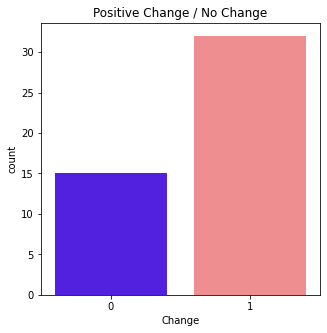

In [9]:
figure, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
chart = sns.countplot(x='Change', data=data, palette="gnuplot2")
chart.set_title('Positive Change / No Change')
    


* In this graph it can be seen that total number of Class 1's is much larger than total number  Class 0's. Nearly 68% of the cities has been affected positively and 32% of the cities has been faced with negative change or stay same in terms of PM2.5 levels.


In [10]:
# Change attribute derived from the Avg_Pollution_2020 and Avg_Pollution_2019 atributes. 
data1 = data.copy()
data1.drop(columns=["Country","City", "Avg_Pollution_2020","Avg_Pollution_2019", "Longitude", "Latitude"], inplace=True) 

In [11]:
#Outlier Detection
def print_outliers(data):
    
    """Return the number of outliers for each feature in the dataframe."""
    
    for column in data.columns:
        if column=="Id":
            continue
            
        quantiles=data[column].quantile(q=[0.25,0.50,0.75]).values
        q1=quantiles[0]
        q2=quantiles[1]
        q3=quantiles[2]
        iqr=q3-q1   
        lower_limit =  q1- 1.5*iqr
        upper_limit =  q3 + 1.5*iqr
        outliers=data[(data[column] < lower_limit) | (data[column] >  upper_limit)][column]
        
        print("number of outliers in {:10s} :\t{}\t({:.2%})".format(column, len(outliers), len(outliers)/len(data[column])))


In [12]:
print_outliers(data1)

number of outliers in Country_Population :	6	(12.77%)
number of outliers in Total_Day_Lockdown :	0	(0.00%)
number of outliers in Development :	0	(0.00%)
number of outliers in Total_Case :	7	(14.89%)
number of outliers in Total_Death :	8	(17.02%)
number of outliers in Change     :	0	(0.00%)


* There are outliers in the *Country_Population, Avg_Pollution_2020, Avg_Pollution_2019, Total_Case, Total_Death*. 

In [13]:
# 'Change' variable is the target.
# Split dataset to X and y sets. X is for independent attribute and y for target attribute.
y = data1.iloc[:,-1:]
X = data1.iloc[:,:-1]

### Standardization

When independent variables in training data are measured in different units, it is important to standardize variables before applying algorithms because one variable may dominate all the others. Since in the dataset all variables are in different scale, before applying any algorithm to the data, explanatory variables are standardized. 

* Except XGBoost and Random Forest.

In [14]:
def standardize(data):
    
    """Return the standardized dataframe."""
    
    data1 = data.copy()
    data1 = StandardScaler().fit_transform(data1)
    data1 = pd.DataFrame(data1, columns = data.columns)
    
    return data1

X = standardize(X)

## Models


- In this section Logistic Regression, Support Vector Machine, Random Forest and K-Nearest Neigbors algorithms is applied to the dataset. Their hyperparameters will be tuned, after tuning general performance of the model will be calculated with repeated 5-Fold cross validation.



 



### Hyperparameter Optimization


* A hyperparameter is external to the model and the value of it cannot be estimated from data. It affects the model performance and because of that hyperparameter tuning is important for all algorithms. 


* In this study, for each of the algorithms best hyperparameters are found with Grid Search Cross Validation. Grid-searching is a method that searching for best combination of hyperparameters. 


* In Scikitlearn, there is a *GridSearchCV*. Grid Search CV tries all possible parameter combinations which are determined by the user and find the best parameter setting for a specificed scoring method. 

* For this study, hypothetical set for each the hyperparameter are defined first, and best combination of hyperparameters are selected by GridSearchCV() method with Stratified 5-fold cross validation on training dataset. 

**Note:** Stratified Kfold CV i a cross validiation technique which is usd when data is imbalanced. It protect the distribution of target in the original data in each fold. 


In [17]:
def parameter_optimization(X, y, estimator, parameters, n_splits):
    
    
    """Return the best parameters using Grid Search method with Stratified Kfold CV."""
    cross_validation_method = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    grid_search_model = GridSearchCV(estimator=estimator, 
                                     param_grid=parameters, 
                                     cv=cross_validation_method,
                                     scoring='f1',
                                     n_jobs=-1,
                                     verbose=2)
    
    grid_search_model.fit(X, y);
    
    return grid_search_model.best_params_

In [18]:
def fit_predict(X, y, estimator):
    
    """Fit model and predict the target, return predicted target."""
    
    tuned_model = estimator
    tuned_model.fit(X, y)
    y_predict_test = tuned_model.predict(X)
    
    return y_predict_test

In [19]:
def model_evaluate(estimator, X, y_true, y_pred):
    
    """Evaluate the perofrmance of model using confusion matrix, balanced accuracy and F1 score."""
    
    confusion_matrix_ = confusion_matrix(y_true, y_pred)
    sns.heatmap(confusion_matrix_, annot=True, fmt="d", cmap="Blues")
    print("Balanced accuracy score: ", "{:.2f}".format(balanced_accuracy_score(y_true, y_pred)), 
          "\nAUC: ", "{:.2f}".format(roc_auc_score(y_true, estimator.predict_proba(X)[:,1])),
          "\nF1-score: ", "{:.2f}".format(f1_score(y_true, y_pred)),
          "\nConfusion Matrix: ")
    

In [27]:
def model_general_performance(estimator, X, y, n_splits):
    
    """Evaluate the performance of the model with whole data, using f1-score and area under curve with cross validation."""
    scoring = {'F1-score': 'f1', 'AUC': 'roc_auc'}
    cv_method = StratifiedKFold(n_splits, shuffle=True, random_state=123)
    cv_result = cross_validate(estimator, X=X, y=y, cv=cv_method, scoring=scoring, return_train_score=True)
    test_f1_score = cv_result["test_F1-score"].mean()
    test_auc = cv_result["test_AUC"].mean()
    print("F1-score:")
    print("Train: ", ": %0.2f "  %  cv_result["train_F1-score"].mean(),
          "\nTest: ", "%0.2f" % cv_result["test_F1-score"].mean(), 
          "\nConfidence Interval: ", "%0.2f, %0.2f" % sms.DescrStatsW(cv_result["test_F1-score"]).tconfint_mean())
          
        
    print("-------------------------------------------------------")
    print("Area Under Curve (AUC):")
    print("Train: ", "%0.2f" % cv_result["train_AUC"].mean(),
          "\nTest: ","%0.2f" % cv_result["test_AUC"].mean(), 
          "\nConfidence Interval: ", "%0.2f, %0.2f" % sms.DescrStatsW(cv_result["test_AUC"]).tconfint_mean()),
    
    


## 1. XGBoost


- XGBoost is one of the most popular machine learning algorithm.


- It is an improved version Gradient Boosting Machine. 


- It is has both algoritmic and system optimization. These are




    1. Approximate greedy algorithm to increase the speed.
    2. Regularized objective function to prevent overfitting.
    3. Sparsity-aware Split Finding algorithm to handle missing data. 
    4. Weighted Quantile Sketch to helping approximate greedy algorithm. 
    5. Parallel Learning to make computation faster.
    6. Cache-aware Access.
    7. Blocks for Out-of-core computation.


### Model Performance without Parameter Optimization

In [21]:
xgb_model = XGBClassifier()

y_predict_xgb = fit_predict(X, y, xgb_model)

[18:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Balanced accuracy score:  0.97 
AUC:  1.00 
F1-score:  0.98 
Confusion Matrix: 


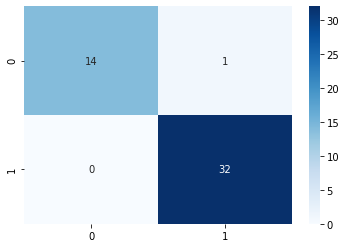

In [22]:
model_evaluate(xgb_model, X, y, y_predict_xgb)

###  Finding The Best Parameters (Hyperparameter Tuning)

In [23]:
xgb_params = {
        'subsample': [0.5, 0.75, 1], # Subsampling ratio of original dataset.
        'colsample_bytree': [0.5, 0.75, 1], # Feature subsampling ratio per tree.
        'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3], # learning rate.
        'max_depth':[2, 3, 5, 7], # Maximum depth of a tree.
        'min_child_weight':[0.5, 1, 2], # Minimum weight of a child node.
        'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1.0, 2], # Regularization parameter.
        'n_estimators': [100, 200, 300, 500],  # Number of estimators in the ensemble.
        }

In [ ]:
xgboost_model = XGBClassifier()

best_parameters_xgboost = parameter_optimization(X=X, y=y, estimator=xgboost_model, parameters=xgb_params, n_splits=5)
best_parameters_xgboost

Fitting 5 folds for each of 15120 candidates, totalling 75600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 2736 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 5000 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 7920 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 11480 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 15696 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 20552 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 26064 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 32216 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 39024 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 46472 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 54576 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 63320 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 72720 

{'colsample_bytree': 1,
 'gamma': 0.3,
 'learning_rate': 0.3,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.5}

Best parameters:

{'colsample_bytree': 1,
 'gamma': 0.3,
 'learning_rate': 0.3,
 'max_depth': 2,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.5}

### Fit & Predict

In [24]:
# Fit and predict the model (predictions are made on test data)
tuned_xgb =  XGBClassifier(colsample_bytree=1, gamma=0.3, max_depth=2, min_child_weight=1, n_estimators=100, subsample=0.5)
y_predict_xgb = fit_predict(X, y, tuned_xgb)

[18:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluate The Performance

Balanced accuracy score:  0.97 
AUC:  0.99 
F1-score:  0.98 
Confusion Matrix: 


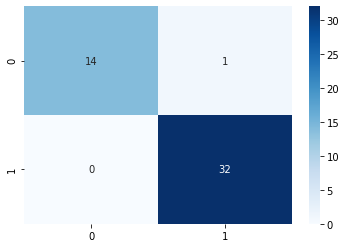

In [25]:
# Evaluate the model on test data
evaluate_xgb = model_evaluate(tuned_xgb, X, y, y_predict_xgb)

###  Cross Validated Performance of XGBoost Model

* F1 score and is selected as general perofrmance evaluation metric.
* Due to the limited number of observations and imbalanced distribution of classes, accuracy score may not be meaningful for evaluating the model.

In [28]:
# General performance of model
general_score_xgb = model_general_performance(tuned_xgb, X, y, n_splits=5)

[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

## 2. Logistic Regression

* Logistic regression turns linear predictions into probabilities by using the logistic function. 
* Logistic Regression does not really have any critical hyperparameters to tune. Therefore Grid Search part is not applied to this algorithm.

### Fit & Predict 

In [29]:
lr_model = LogisticRegression()

y_predict_lr = fit_predict(X, y, lr_model)

### Evaluate The Performance 

Balanced accuracy score:  0.57 
AUC:  0.72 
F1-score:  0.79 
Confusion Matrix: 


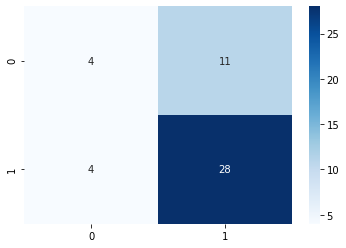

In [30]:
# Evaluate the perofrmance of model on test data
model_evaluate(lr_model, X, y, y_predict_lr)

### Cross Validated Performance of Logistic Regression Model

In [31]:
# General performance of the model
general_score_lr = model_general_performance(lr_model, X, y, n_splits=5)

F1-score:
Train:  : 0.80  
Test:  0.80 
Confidence Interval:  0.65, 0.95
-------------------------------------------------------
Area Under Curve (AUC):
Train:  0.75 
Test:  0.60 
Confidence Interval:  0.42, 0.79


## 3. Random Forest

Random Forest(s) is proposed by Breiman (2001). It is a popular machine learning algorithm. Random Forest is preferred by the user for its good performance and ease of use. 

It contains two types of randomness. 
    1. Bootstrap aggregating (bagging),
    2. Randm feature selection.

Hyperparameters: 
- max_features: the number of features to consider when looking for the best split,
- n_estimators: the number of trees in the forest.

According to Breiman (2001), these two parameters are the most important parameters for Random Forest. 

### Performance without Hyperparameter Tuning

In [32]:
rf_model = RandomForestClassifier(random_state=123)
y_pred_rf = fit_predict(X,y, rf_model)

Balanced accuracy score:  1.00 
AUC:  1.00 
F1-score:  1.00 
Confusion Matrix: 


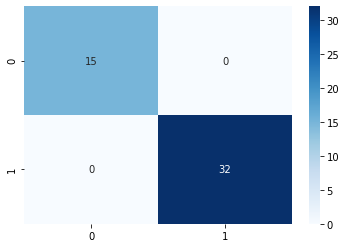

In [33]:
model_evaluate(rf_model, X, y, y_pred_rf)

### Hyperparameter Tuning

In [34]:
random_forest = RandomForestClassifier(random_state=123)

parameters_random_forest = {"max_features": [2, 3, 5, 7, 10],
                            "n_estimators": [100, 300, 500, 700, 1000]}

best_parameters_random_forest = parameter_optimization(X,y, estimator=random_forest, parameters=parameters_random_forest, n_splits=5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [35]:
best_parameters_random_forest

{'max_features': 2, 'n_estimators': 100}

### Fit & Predict

In [36]:
# Fit and predict the model

tuned_rf = RandomForestClassifier(max_features=2, n_estimators=100, random_state=123)

y_predict_rf = fit_predict(X, y, tuned_rf)

### Evaluate The Performance

Balanced accuracy score:  1.00 
AUC:  1.00 
F1-score:  1.00 
Confusion Matrix: 


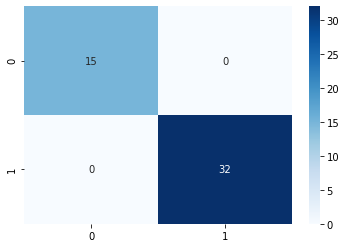

In [37]:
# Evaluate the perofrmance of model on test data
evaluate_rf = model_evaluate(tuned_rf, X, y, y_predict_rf)

8 of the actual positive instances are correctly classified as positive, 3 of the instances is correctly classified as negative. 1 of the instances are incorrectly classified as positive and 3 of the instances are incorrectly classified as negative. 

### Cross Validated Performance of Random Forest Model

In [38]:
# General perofrmance of the model
general_score_rf = model_general_performance(tuned_rf, X, y, n_splits=5)

F1-score:
Train:  : 1.00  
Test:  0.69 
Confidence Interval:  0.42, 0.95
-------------------------------------------------------
Area Under Curve (AUC):
Train:  1.00 
Test:  0.56 
Confidence Interval:  0.21, 0.92


## 4. k-Nearest Neighbor Classifier

* K nearest neighbors is a simple algorithm that classifies based on a distance function. 

* In this study, different k number of neighbor values are tried for the hyperparameter tuning. 

    1. Number of neighbors considered 1 to 8, 


### Performance without Hyperparameter Tuning

Balanced accuracy score:  0.69 
AUC:  0.75 
F1-score:  0.82 
Confusion Matrix: 


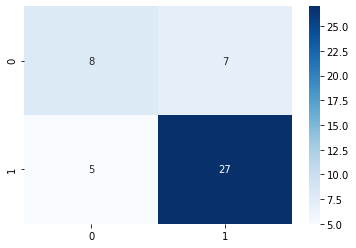

In [39]:
kNN_model = KNeighborsClassifier()
y_pred_knn = fit_predict(X, y, kNN_model)
model_evaluate(kNN_model, X, y, y_pred_knn)

### Hyperparameter Tuning

In [40]:
parameters_kNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8]}

best_parameters_kNN = parameter_optimization(X, y, kNN_model, parameters_kNN, 5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [41]:
best_parameters_kNN

{'n_neighbors': 5}

### Fit & Predict

In [42]:
# Fit and predict the model (predictions are made on test data)
tuned_kNN = KNeighborsClassifier(n_neighbors=5)
y_predict_kNN = fit_predict(X, y, tuned_kNN)

- Hyperparameters are optimized and the best parameters are selected as k=5.

### Evaluate The Performance

Balanced accuracy score:  0.69 
AUC:  0.75 
F1-score:  0.82 
Confusion Matrix: 


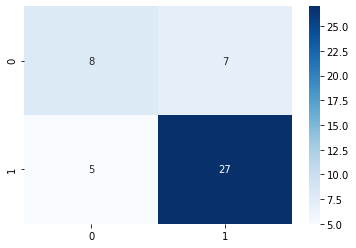

In [43]:
# Evaluate the perofrmance of model on test data
evaluate_kNN = model_evaluate(tuned_kNN, X, y, y_predict_kNN)
evaluate_kNN

### General Performance of K-Nearest Neighbors

In [44]:
# General perofrmance of the model
general_score_kNN = model_general_performance(tuned_kNN, X, y, 5)

F1-score:
Train:  : 0.82  
Test:  0.75 
Confidence Interval:  0.70, 0.81
-------------------------------------------------------
Area Under Curve (AUC):
Train:  0.74 
Test:  0.58 
Confidence Interval:  0.47, 0.70


## Final Evaluation

### ROC Curves

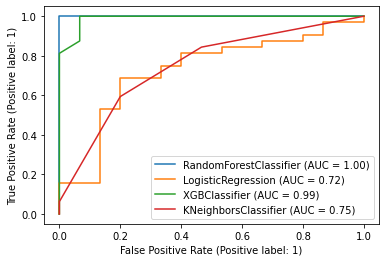

In [45]:
disp = plot_roc_curve(tuned_rf, X, y)
plot_roc_curve(lr_model, X, y, ax=disp.ax_);
plot_roc_curve(tuned_xgb, X, y, ax=disp.ax_);
plot_roc_curve(tuned_kNN, X, y,ax=disp.ax_);


In [49]:
def cv_score(model, X, y, scoring):
    
    """Returns the cross-validated algorithm score for the specified evaluation metric."""
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [50]:
models = [tuned_xgb, lr_model, tuned_rf, tuned_kNN]

# cross validate the models and store results
results1,results2, names = list(), list(), list()

for model in models:
  names_ = model.__class__.__name__
  names.append(names_)
  f1_score = cv_score(model, X, y, 'f1')
  results1.append(f1_score)
  print('>%s %.3f (%.3f)' % (names_, f1_score.mean(), f1_score.std()))
  auc = cv_score(model, X, y, 'roc_auc')
  results2.append(auc)  
  print('>%s %.3f (%.3f)' % (names_, auc.mean(), auc.std()))
plt.figure(figsize=(10,10))


>XGBClassifier 0.846 (0.104)
>XGBClassifier 0.638 (0.350)
>LogisticRegression 0.801 (0.106)
>LogisticRegression 0.605 (0.135)
>RandomForestClassifier 0.685 (0.190)
>RandomForestClassifier 0.562 (0.256)
>KNeighborsClassifier 0.751 (0.040)
>KNeighborsClassifier 0.583 (0.081)


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

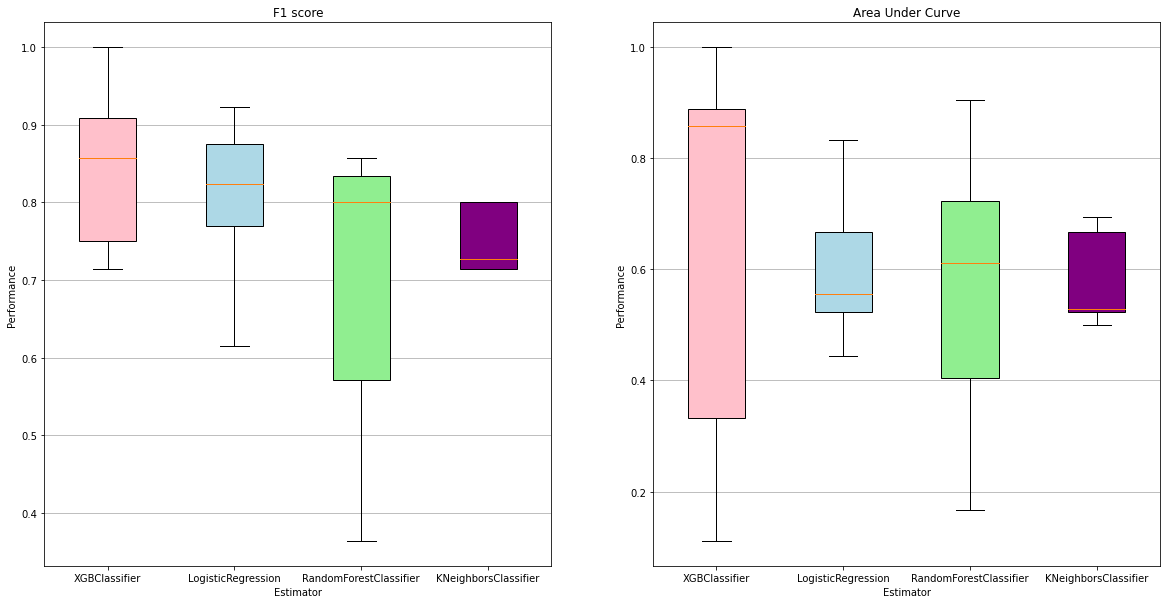

In [63]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
# rectangular box plot

bplot1 = ax1.boxplot(results1,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=names)  # will be used to label x-ticks
ax1.set_title('F1 score')
plt.xticks(fontsize=12)

# notch shape box plot


bplot2 = ax2.boxplot(results2,  
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=names)  # will be used to label x-ticks
ax2.set_title('Area Under Curve')
plt.xticks(fontsize=10)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'purple']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Estimator')
    ax.set_ylabel('Performance')

plt.show()

*  For F1-score XGBoost has the best perofrmance, it has tight intevals and it outperfrom the other algorithms. However, for AUC, it has large intervals. Similarly, Random Forest has wide intervals for all overall performance. For ROC curve, they have the best performance. XGBoost can be a good choice for this study. 

* For both F1-score and AUC  logistic regression has good performance. 

* k-NN has good standard deviation and has tight intervals. However, it has the worst performance among them in the average.

## References 


Banerjee, P. (2020, March 13). KNN Classifier Tutorial in Python. Kaggle. https://www.kaggle.com/prashant111/knn-classifier-tutorial

Cross Validation (2019) Retrieved May 31,2020, from https://scikit-learn.org/stable/modules/cross_validation.html


Grid Search Cross Validation. (2019). Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

Logistic Regression (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Kumar, D. (2020, May 28). Covid-19 Analysis, Visualization & Comparisons. Kaggle. https://www.kaggle.com/imdevskp/covid-19-analysis-visualization-comparisons

Model Evaluation (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/model_evaluation.html

Model Validation in Python. (2018, June 19). Retrieved May 2, 2020, from https://www.datavedas.com/model-validation-in-python/

Random Forest Classifier (2019) Retrieved May 31, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Receiver Operating Characteristic (ROC) (2019) Retrived May 31, 2020, from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

SVM Hyperparameter Tuning Using GridSearcCV. (n.d.). Retrieved May 31, 2020, from https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/